## Import CNN/Daily Mail Dataset

In [1]:
from datasets import load_dataset
from utils.sample import sample, print_sample
import torch
import os
import random
import numpy as np
from transformers import set_seed

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

corpus = load_dataset("cnn_dailymail", "3.0.0")
train_corpus = corpus["train"]
test_corpus = corpus["test"]

example = sample(train_corpus)
print_sample(example, max_chars=200)

Article:
"(CNN) -- A magnitude 7.9 earthquake struck off the coast of central Peru on Wednesday evening, killing 15 people and leaving 70 hurt, President Alan Garcia said on national television. Pedestrians tr...

Highlights:
"NEW: Tsunami warnings and watches canceled, as is Hawaii's advisory .\nAt least 15 people killed, 70 injured in quake .\nQuake was felt for two minutes; people ran out of office buildings in panic .\...

Id:
"fca2c956e45391f8b205cbe78e6b454321d49305"



## Compare BART and PEGASUS models

### Select Samples

In [2]:
# Select 100 articles
NUM_SAMPLES = 100
articles = sample(test_corpus, NUM_SAMPLES)

### Import Models

In [3]:
from utils.pipeline import make_bart_pipeline, make_pegasus_pipeline

bart_pipeline = make_bart_pipeline()
pegasus_pipeline = make_pegasus_pipeline()

Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Prepare Summarizers

In [4]:
from core.summarizer import Summarizer

model_configs = {
    'bart': Summarizer(bart_pipeline),
    'pegasus': Summarizer(pegasus_pipeline)
}

### Generate & Evaluate Summaries

Evaluating: BART...

Generating summaries for 100 articles...

Completed in 00:11:50.14


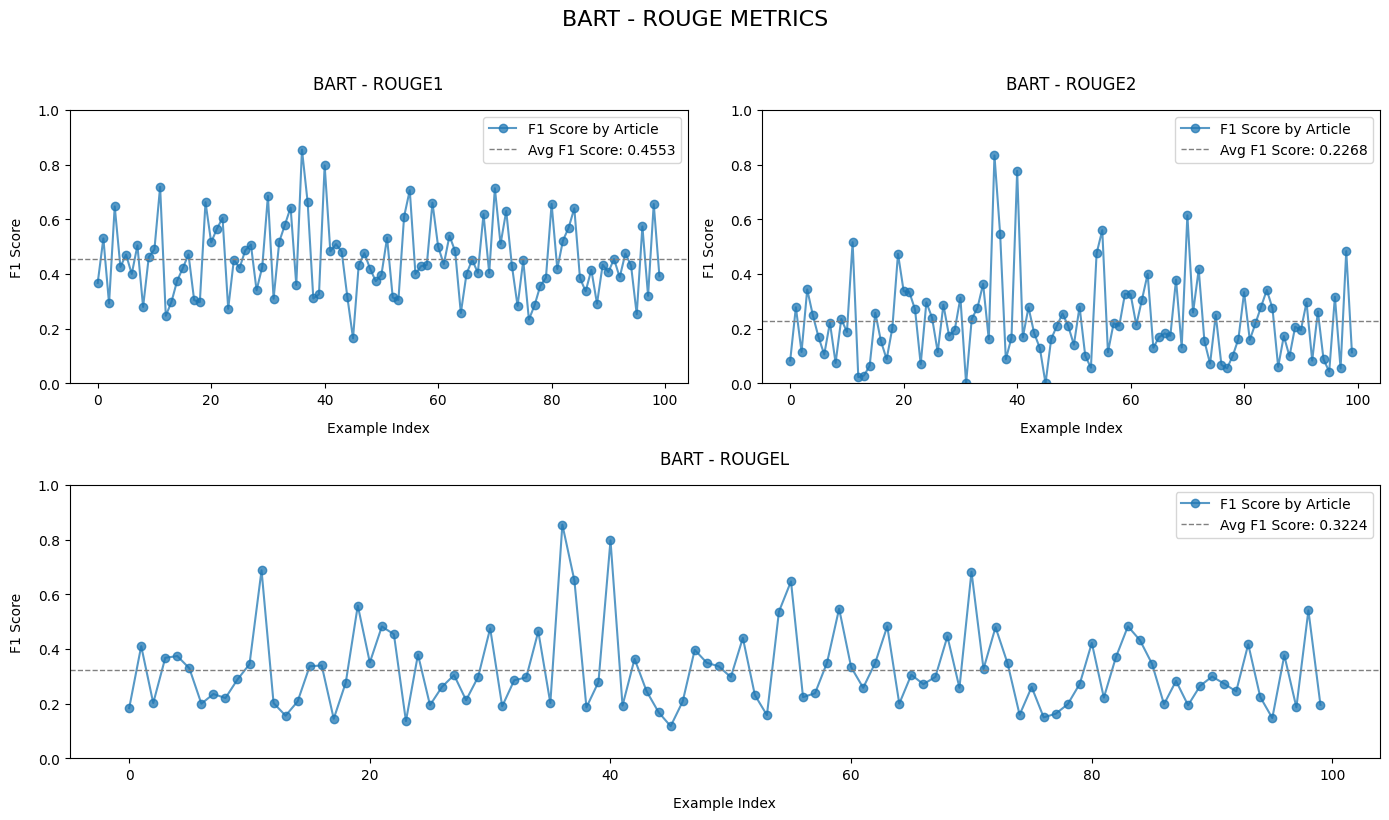

Evaluating: PEGASUS...

Generating summaries for 100 articles...

Completed in 00:15:57.91


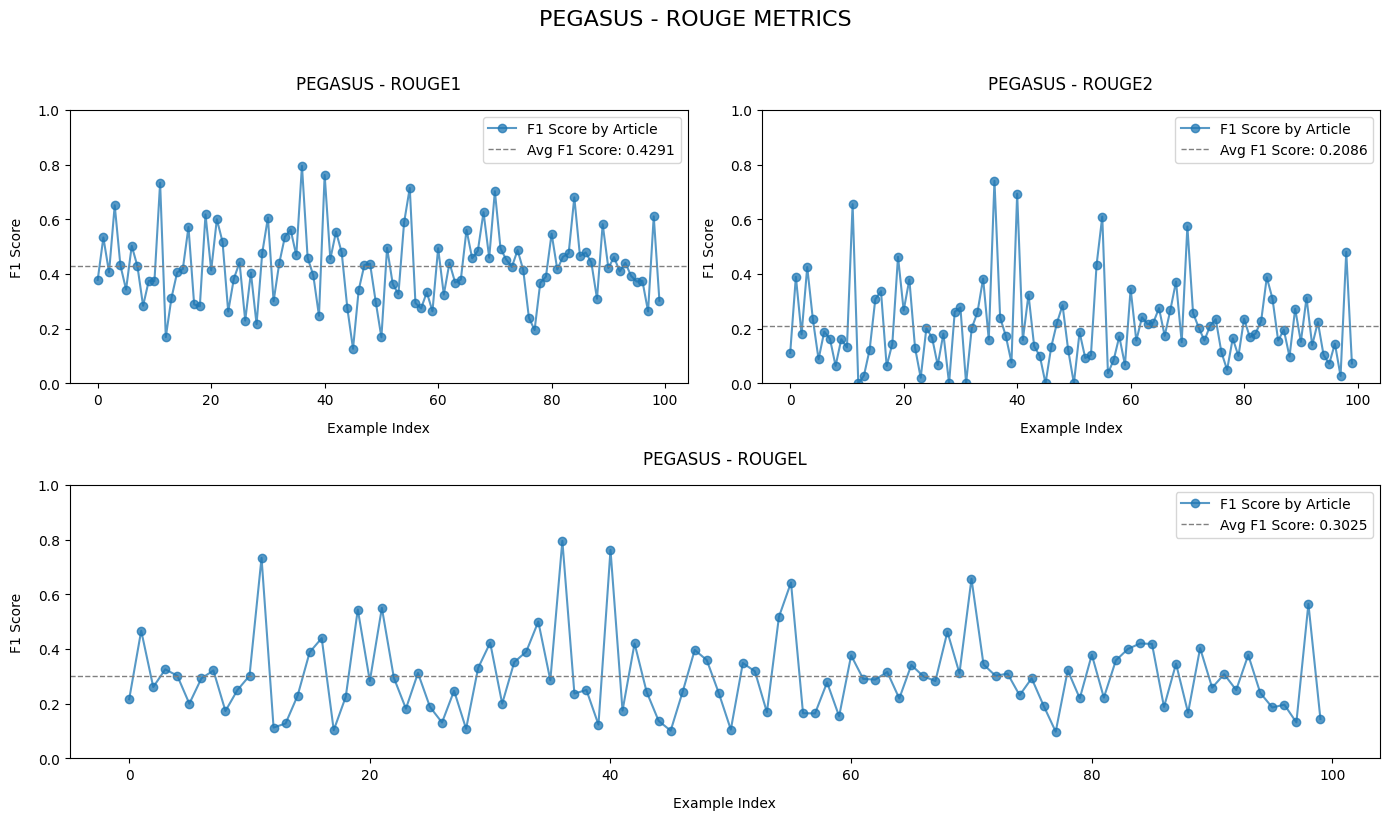

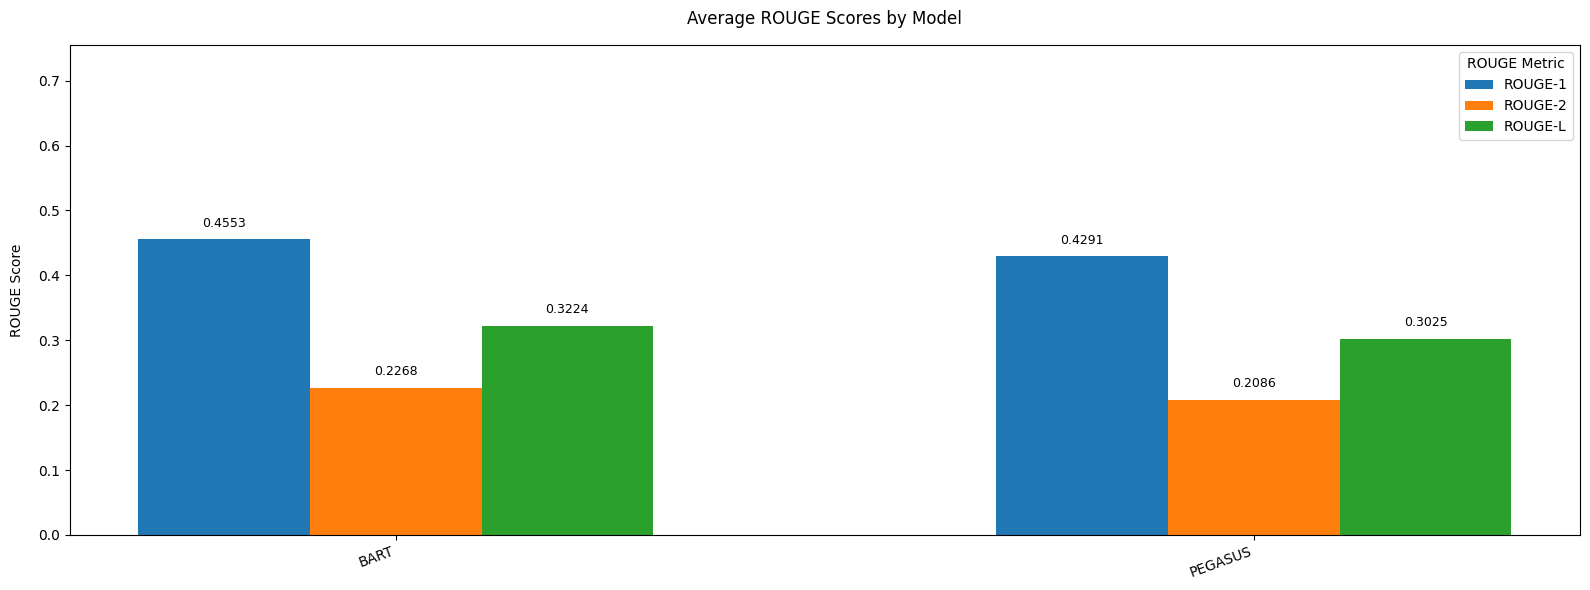

In [5]:
from utils.sum_eval import sum_eval
from utils.plot import plot_avg_rouge, plot_avg_manual_score
import pandas as pd

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)

model_scores = sum_eval(articles, model_configs)
df_models = pd.DataFrame(model_scores).T.sort_values(by='rougeL', ascending=False)

plot_avg_rouge(model_scores, save_path=os.path.join(results_dir, 'avg_rouge_scores'))

### Extrinsic Evaluation

In [6]:
# Select 10 articles
NUM_RANDOM_SAMPLES = 10
manual_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

In [7]:
# Generate summaries
bart_summarizer = model_configs['bart']
bart_summaries = bart_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:12.36


##### BART

In [37]:
from evaluation.extrinsic_evaluator import ExtrinsicEvaluator

# Evaluate Bart
bart_evaluator = ExtrinsicEvaluator(bart_summaries)
bart_evaluator.evaluate('BART')
bart_id_to_score = {
    "b02798e17147839d052ead06f9be7674d6ab5a8d": 4,
    "c38207a8ba7332bf8fc449770b2554510fa1482a": 5,
    "13ec87a8f0fb2021b2fc9b927d75fd5a0acc08c4": 4,
    "3b0a89947b49342cc8ab6a94c4a48f1c4776806e": 3,
    "833767dd729b944a564361924a8b002e58782d0a": 5,
    "a082f48c499c160178b3bb968d8e2b3d7892b7a7": 5,
    "1edc5af4d49e174fb81019e66deac9b52e71013c": 5,
    "ac21c26ebbe99747ed51f317904f4ca75873e574": 5,
    "c7dd1a2c3ac27f9f8d92361a1d41c8199d3ab8d0": 5,
    "069c9ea4fc03755f1f460f8890a5c2f198646ca0": 5,
}
bart_evaluator.submit_scores(bart_id_to_score)


Manually evaluating BART...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. I w

##### PEGASUS

In [9]:
# Generate Summaries
pegasus_summarizer = model_configs['pegasus']
pegasus_summaries = pegasus_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:37.88


In [40]:
# Evaluate PEGASUS
pegasus_evaluator = ExtrinsicEvaluator(pegasus_summaries)
pegasus_evaluator.evaluate('PEGASUS')
pegasus_id_to_score = {
    "b02798e17147839d052ead06f9be7674d6ab5a8d": 3,  # Repeated the same sequence: "The 'Didier Drogba Foundation,' contribute financial and material support in education and health including school bags for the school children"
    "c38207a8ba7332bf8fc449770b2554510fa1482a": 4,
    "13ec87a8f0fb2021b2fc9b927d75fd5a0acc08c4": 5,  # better than the BART one
    "3b0a89947b49342cc8ab6a94c4a48f1c4776806e": 3,  # Good, but didn't finish its thought and struggled to get to the point
    "833767dd729b944a564361924a8b002e58782d0a": 4,
    "a082f48c499c160178b3bb968d8e2b3d7892b7a7": 3,  # missed the part where the lion was walked around on a leash
    "1edc5af4d49e174fb81019e66deac9b52e71013c": 5,  # better than the BART one
    "ac21c26ebbe99747ed51f317904f4ca75873e574": 4,
    "c7dd1a2c3ac27f9f8d92361a1d41c8199d3ab8d0": 4,  # No mention of 250,000 prize but better otherwise
    "069c9ea4fc03755f1f460f8890a5c2f198646ca0": 5,
}
pegasus_evaluator.submit_scores(pegasus_id_to_score)

Manually evaluating PEGASUS...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. 

#### Plot Manual Scores

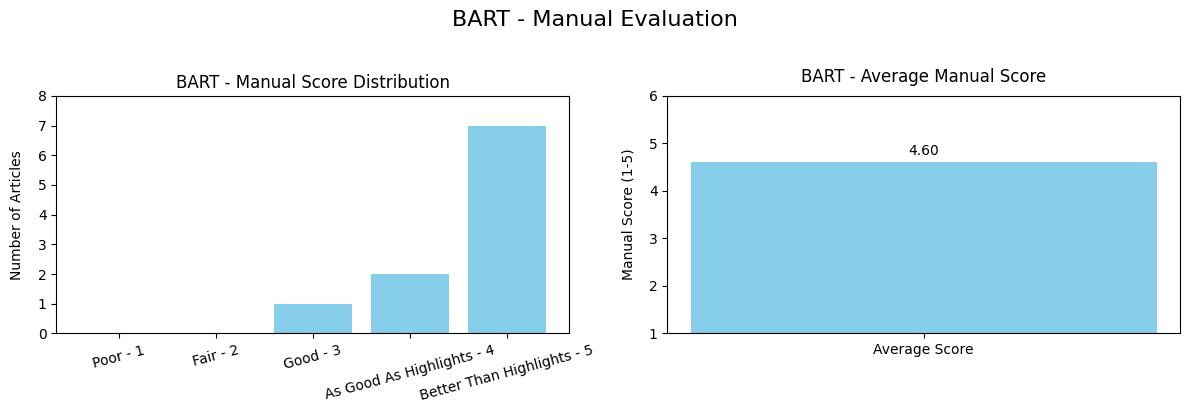

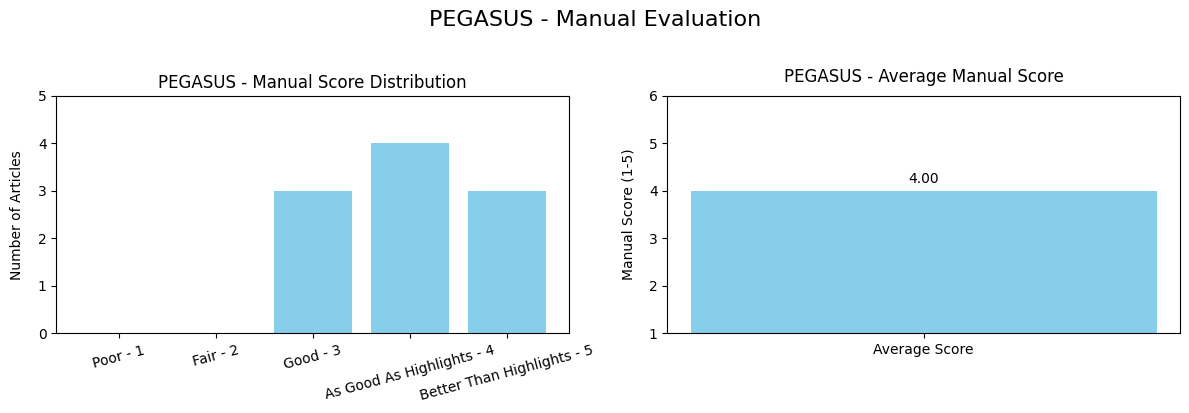

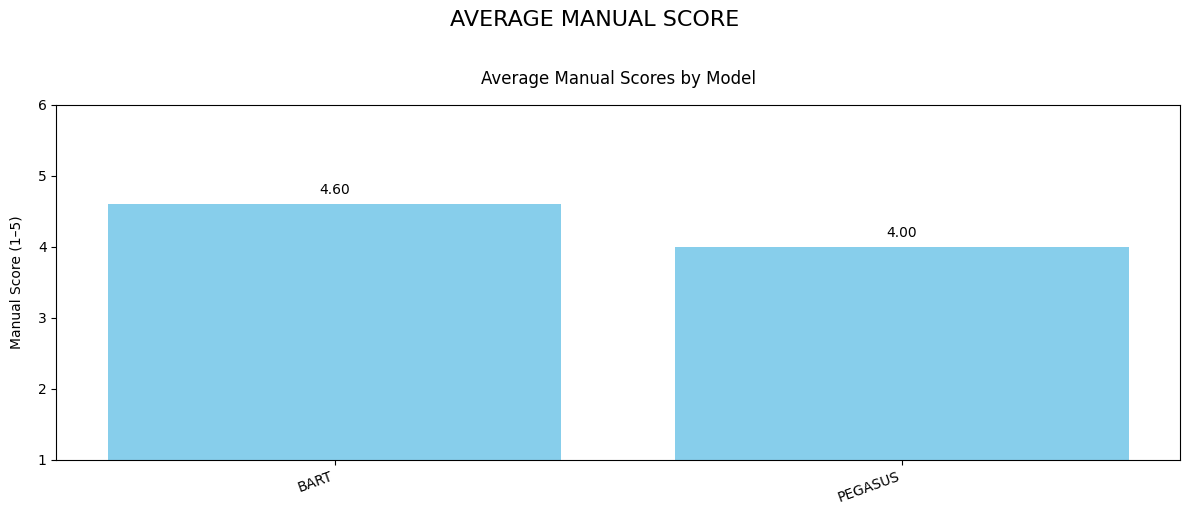

In [41]:
bart_evaluator.plot('BART', save_path=os.path.join(results_dir, 'bart'))
pegasus_evaluator.plot('PEGASUS', save_path=os.path.join(results_dir, 'pegasus'))

avg_manual_scores = {
    'bart': bart_evaluator.avg_score,
    'pegasus': pegasus_evaluator.avg_score
}

plot_avg_manual_score(avg_manual_scores, save_path=os.path.join(results_dir, 'avg_manual_scores'))

##### BART default model outperforms PEGASUS default model

## Ablation Study

### Model Configs

In [12]:
DEFAULT_MIN_LENGTH = 30
DEFAULT_MAX_LENGTH = 100

bart_pipeline = make_bart_pipeline()
pegasus_pipeline = make_pegasus_pipeline()

ablation_configs = {
    # === BART configs ===
    # Default BART model
    'bart_default': Summarizer(
        bart_pipeline,
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Beam Search configs
    'bart_beam_4': Summarizer(
        bart_pipeline,
        num_beams=4,  # Moderate beam search
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    'bart_beam_16': Summarizer(
        bart_pipeline,
        num_beams=16,  # Expensive beam search
        length_penalty=1.2,  # Favor longer outputs (stabilizes high beam count)
        no_repeat_ngram_size=3,  # Avoid repeating tri-grams (stabilizes high beam count)
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Length penalty configs
    'bart_len_pen_08': Summarizer(
        bart_pipeline,
        num_beams=4,  # Moderate beam search
        length_penalty=0.8,  # Favor shorter outputs
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    'bart_len_pen_12': Summarizer(
        bart_pipeline,
        num_beams=4,  # Moderate beam search
        length_penalty=1.2,  # Favor longer outputs
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Non-repetition of tri-grams
    'bart_nr_3gram': Summarizer(
        bart_pipeline,
        num_beams=4,  # Moderate beam search
        no_repeat_ngram_size=3,  # Avoid repeating tri-grams
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Enable sampling
    'bart_sample': Summarizer(
        bart_pipeline,
        do_sample=True,  # Enable sampling
        top_p=0.9,  # Randomly choose from top 90% of tokens at each step
        temperature=1.2,  # Flatten distribution so lower probability tokens are more likely
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # === PEGASUS configs ===
    'pegasus_default': Summarizer(
        pegasus_pipeline,
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Moderately robust
    'pegasus_beam_4': Summarizer(
        pegasus_pipeline,
        num_beams=4,  # Moderate beam search
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Expensive and robust
    'pegasus_beam_16_lenpen_12_nr3': Summarizer(
        pegasus_pipeline,
        num_beams=16,  # Expensive beam search
        length_penalty=1.2,  # Favor longer outputs (stabilizes high beam count)
        no_repeat_ngram_size=3,  # Avoid repeating tri-grams (stabilizes high beam count)
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
}

Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Prepare Summarizers

### Generate & Evaluate Summaries

Evaluating: BART_DEFAULT...

Generating summaries for 100 articles...

Completed in 00:10:2.24


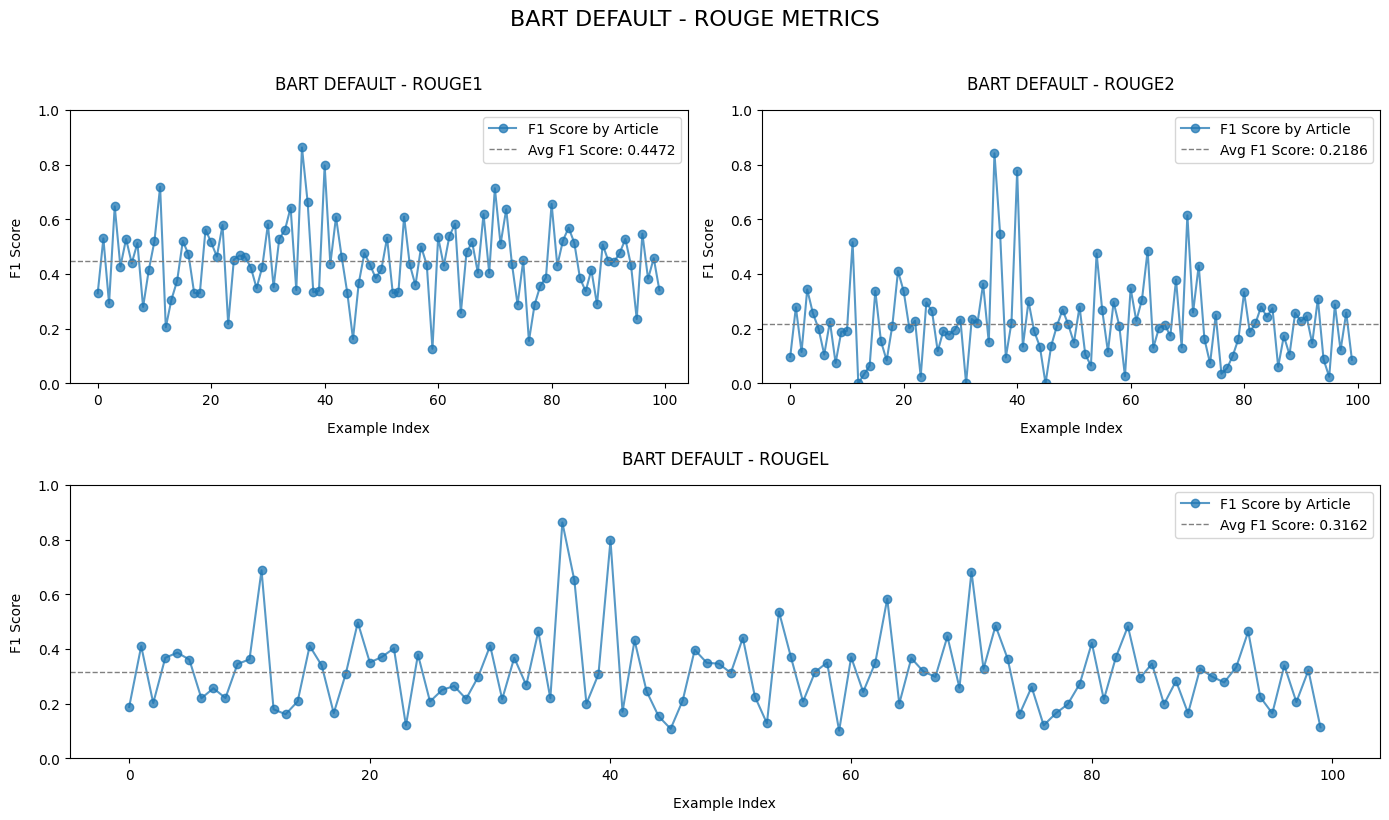

Evaluating: BART_BEAM_4...

Generating summaries for 100 articles...

Completed in 00:10:13.55


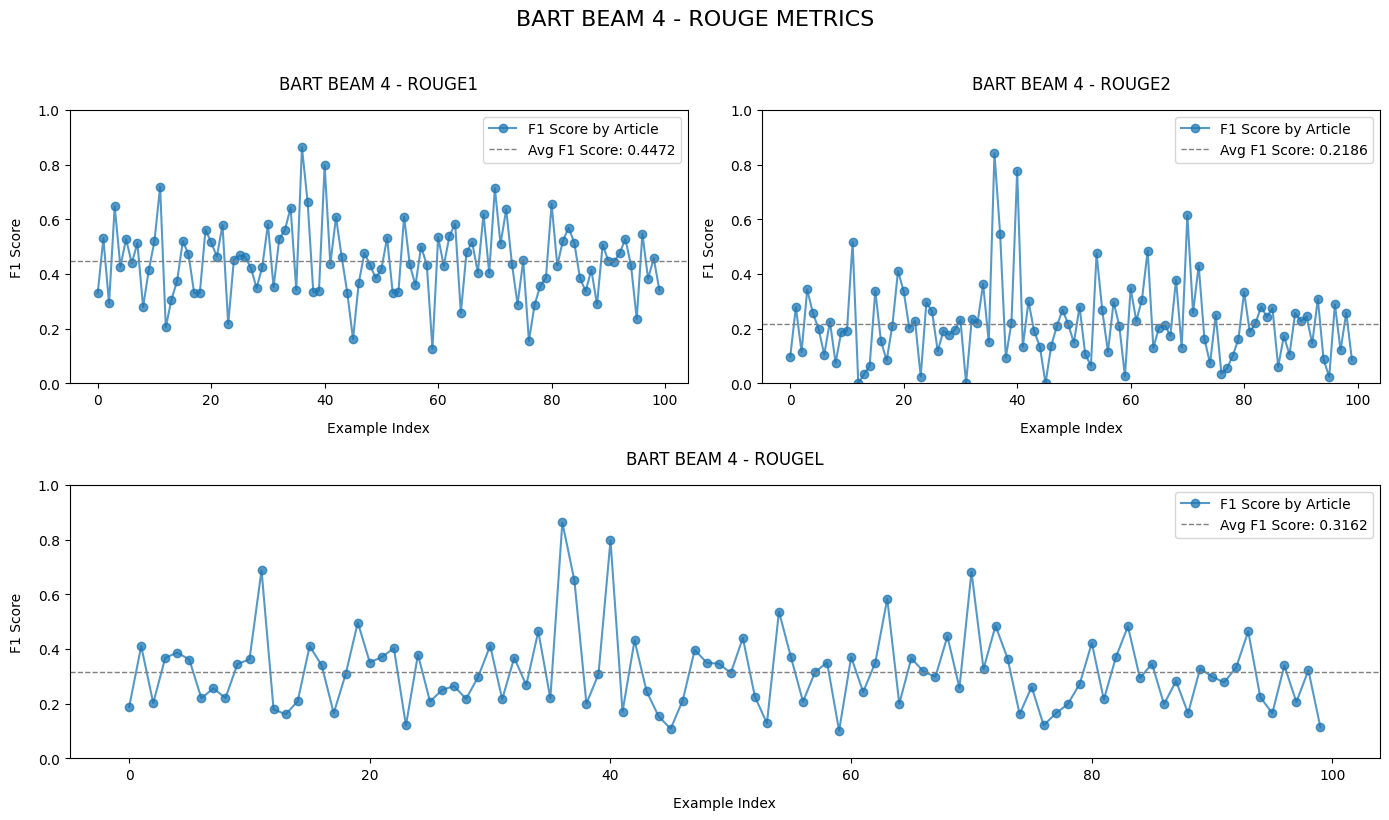

Evaluating: BART_BEAM_16...

Generating summaries for 100 articles...

Completed in 00:19:9.88


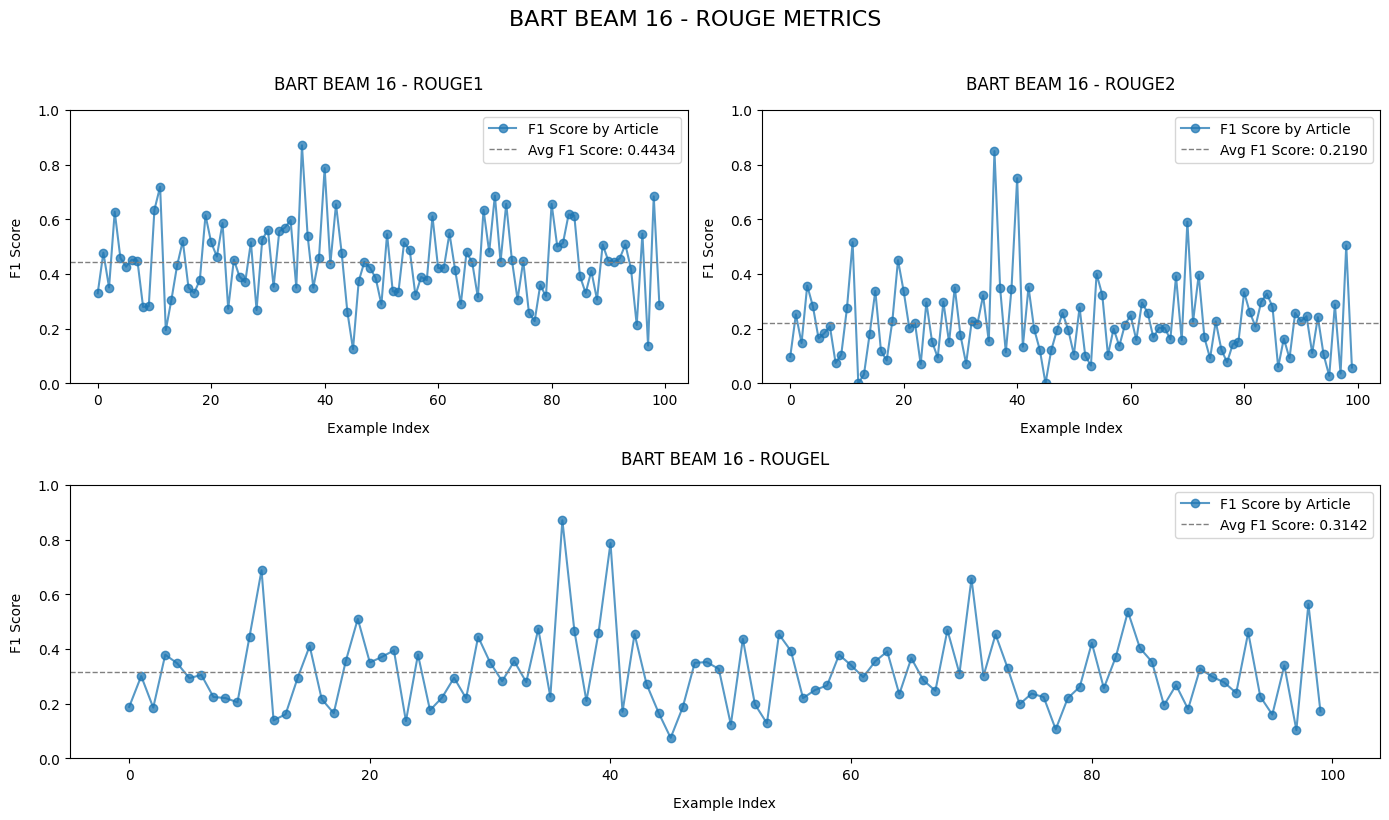

Evaluating: BART_LEN_PEN_08...

Generating summaries for 100 articles...

Completed in 00:10:43.28


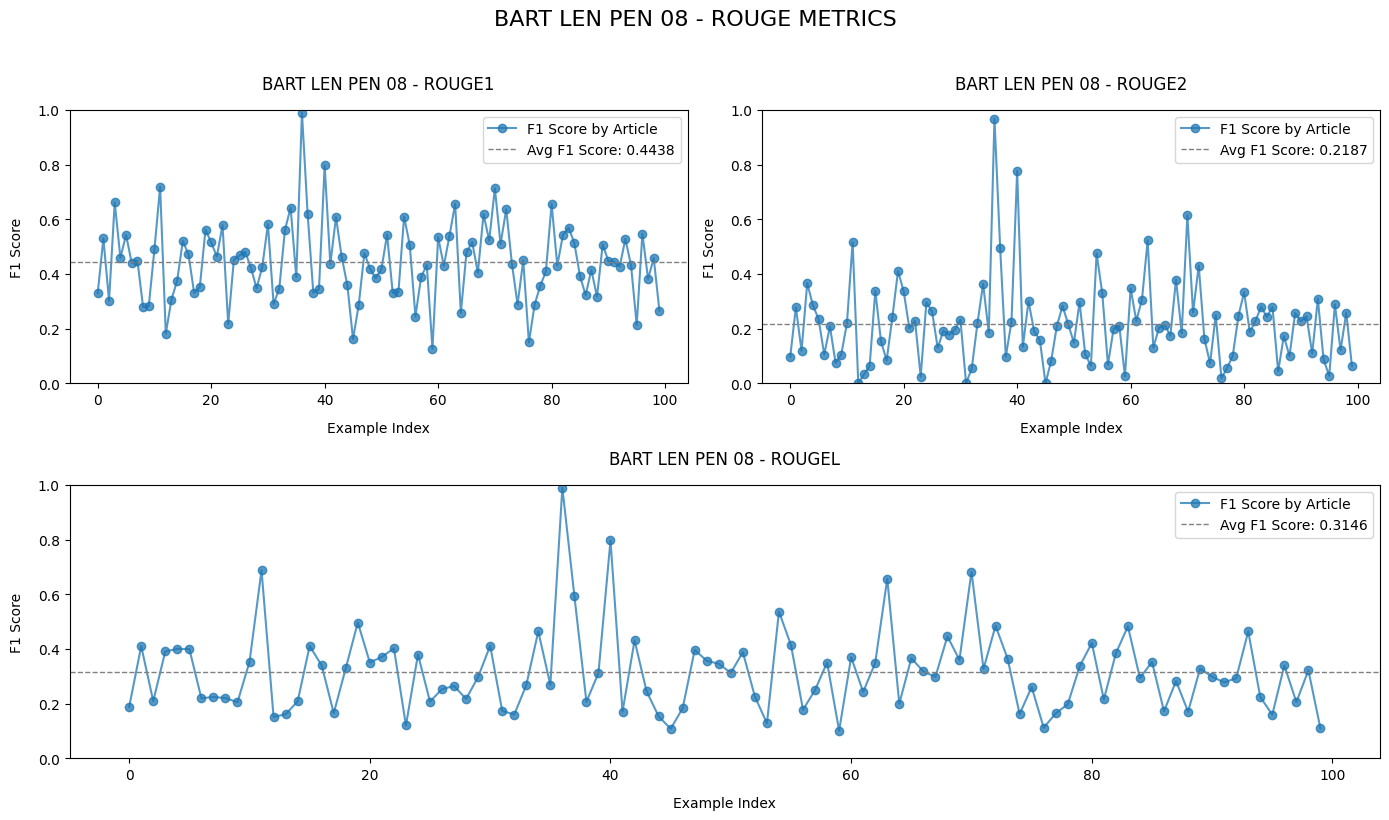

Evaluating: BART_LEN_PEN_12...

Generating summaries for 100 articles...

Completed in 00:10:53.81


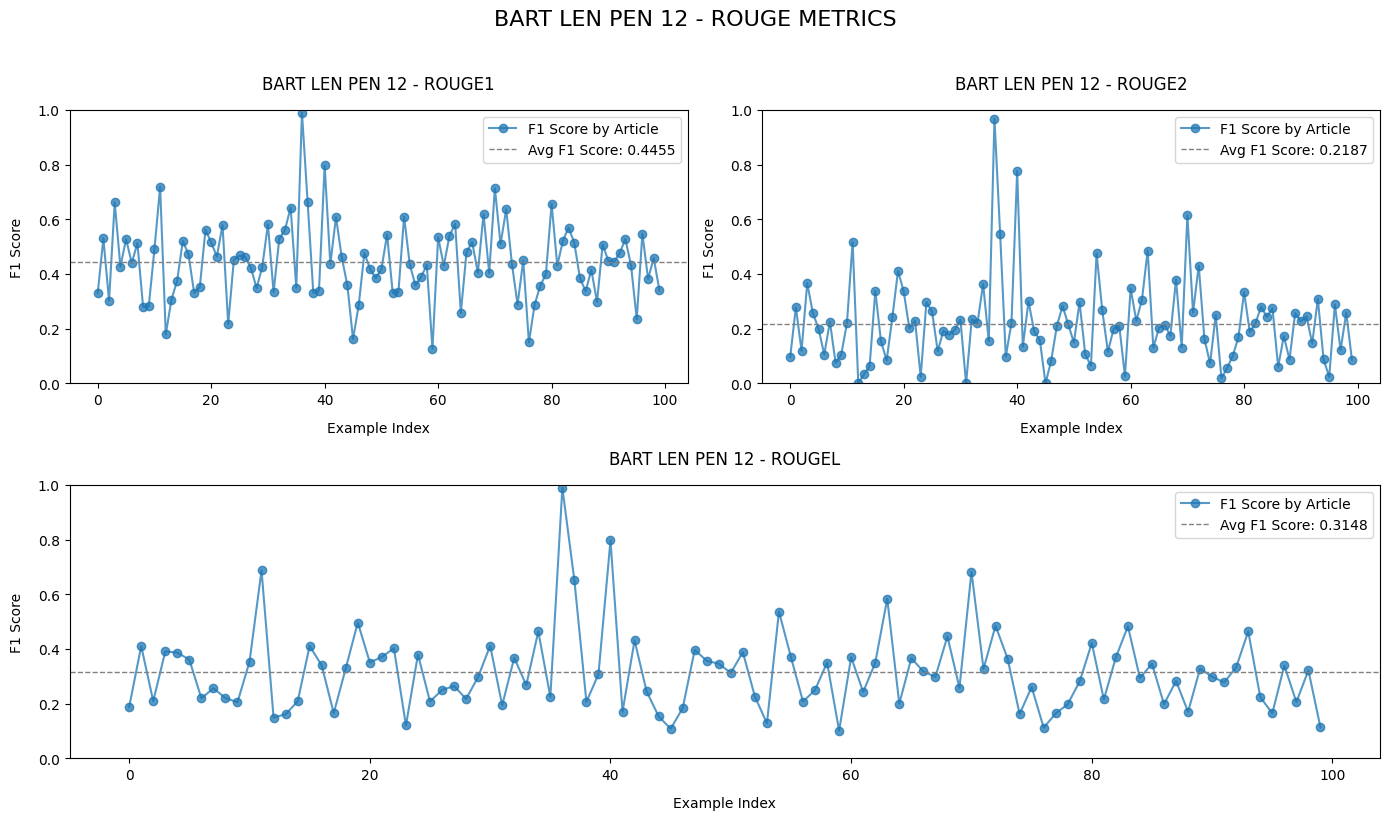

Evaluating: BART_NR_3GRAM...

Generating summaries for 100 articles...

Completed in 00:10:57.23


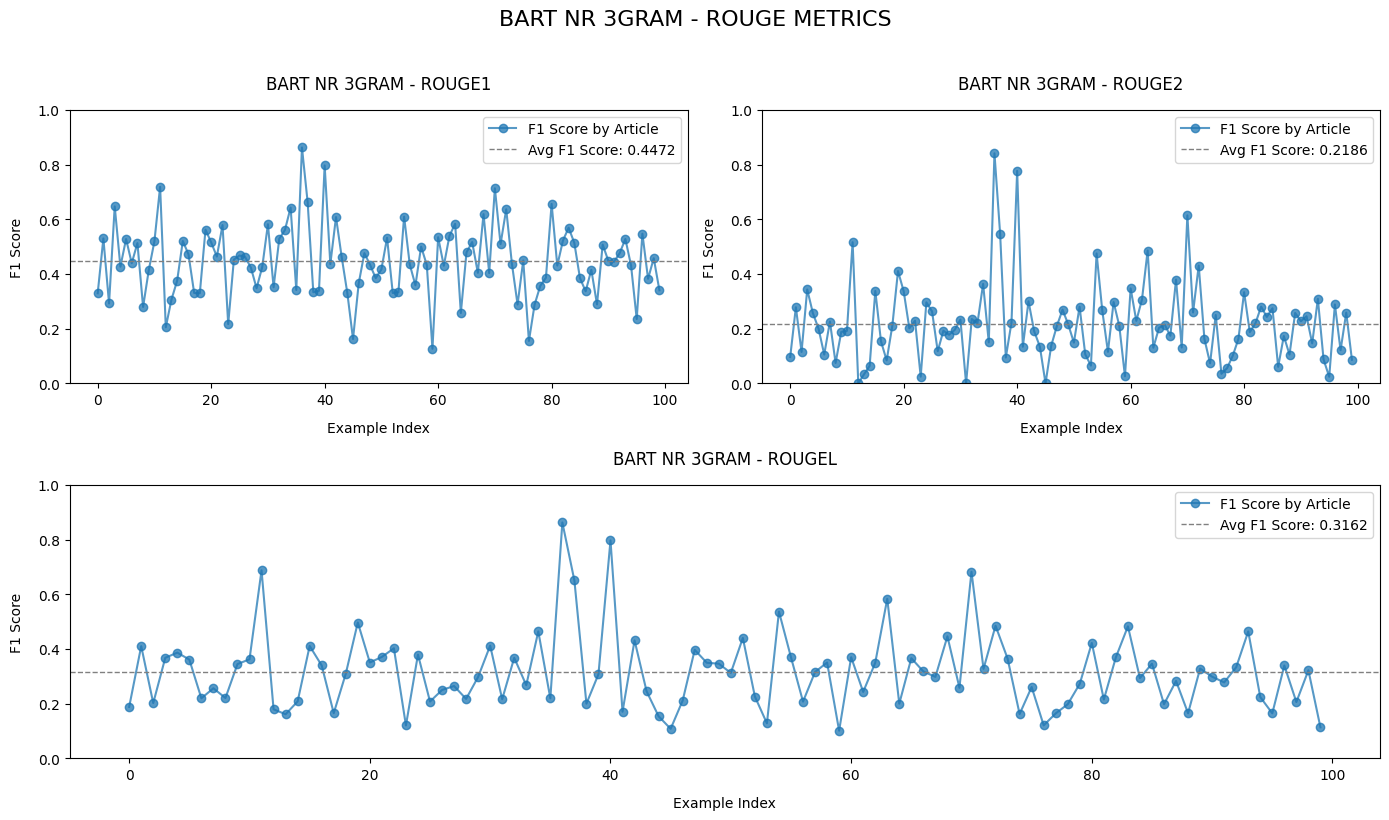

Evaluating: BART_SAMPLE...

Generating summaries for 100 articles...

Completed in 00:11:53.33


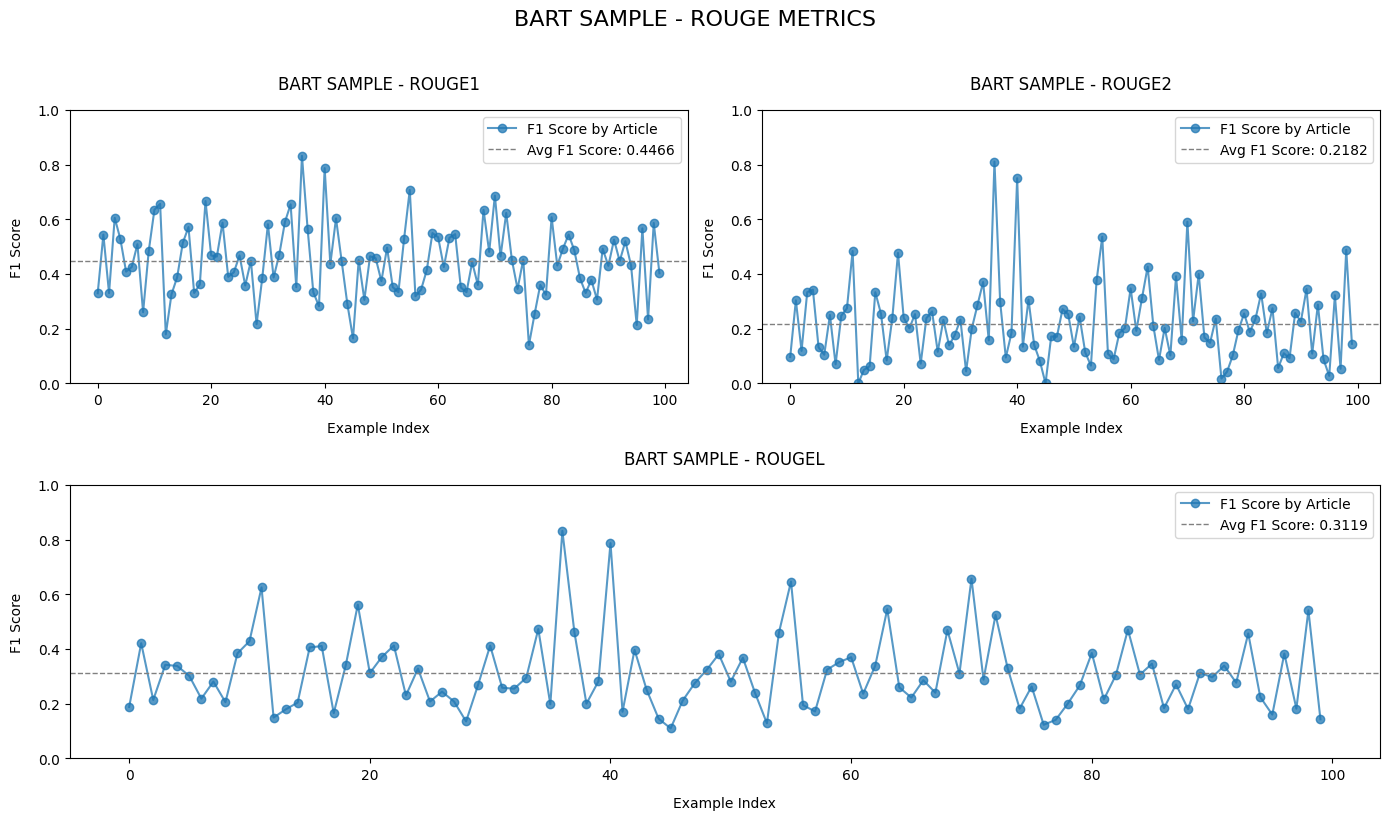

Evaluating: PEGASUS_DEFAULT...

Generating summaries for 100 articles...

Completed in 00:15:2.94


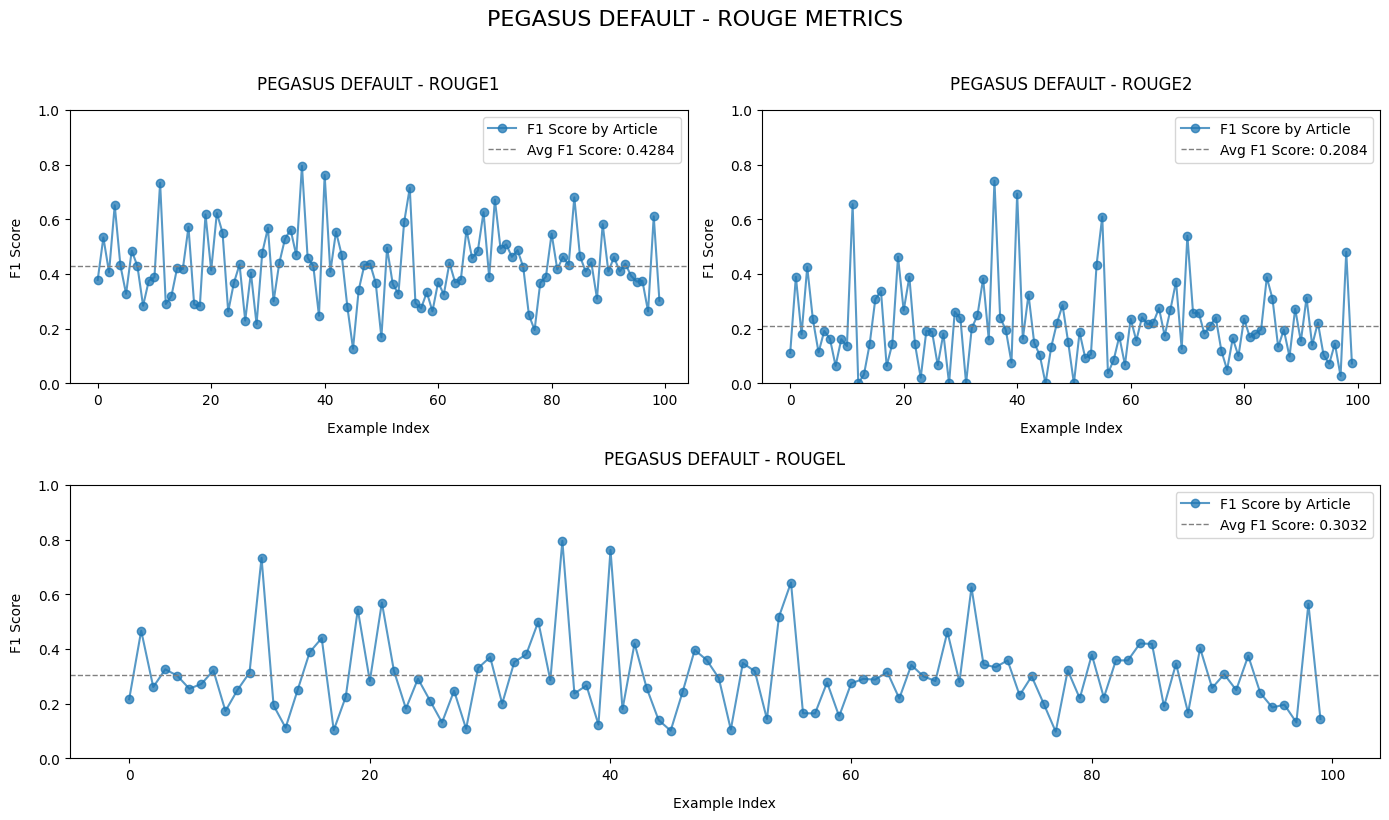

Evaluating: PEGASUS_BEAM_4...

Generating summaries for 100 articles...

Completed in 00:14:59.89


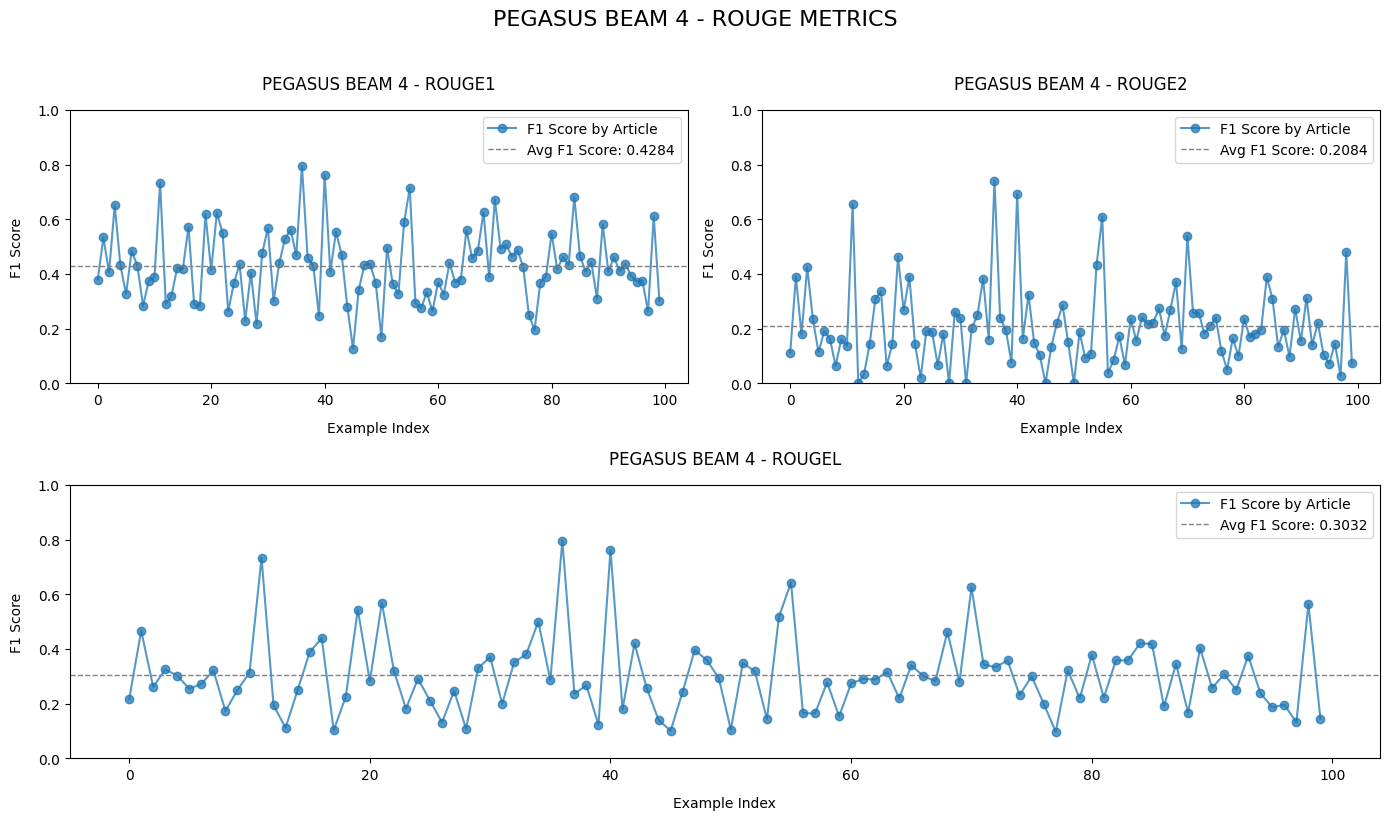

Evaluating: PEGASUS_BEAM_16_LENPEN_12_NR3...

Generating summaries for 100 articles...

Completed in 00:27:31.78


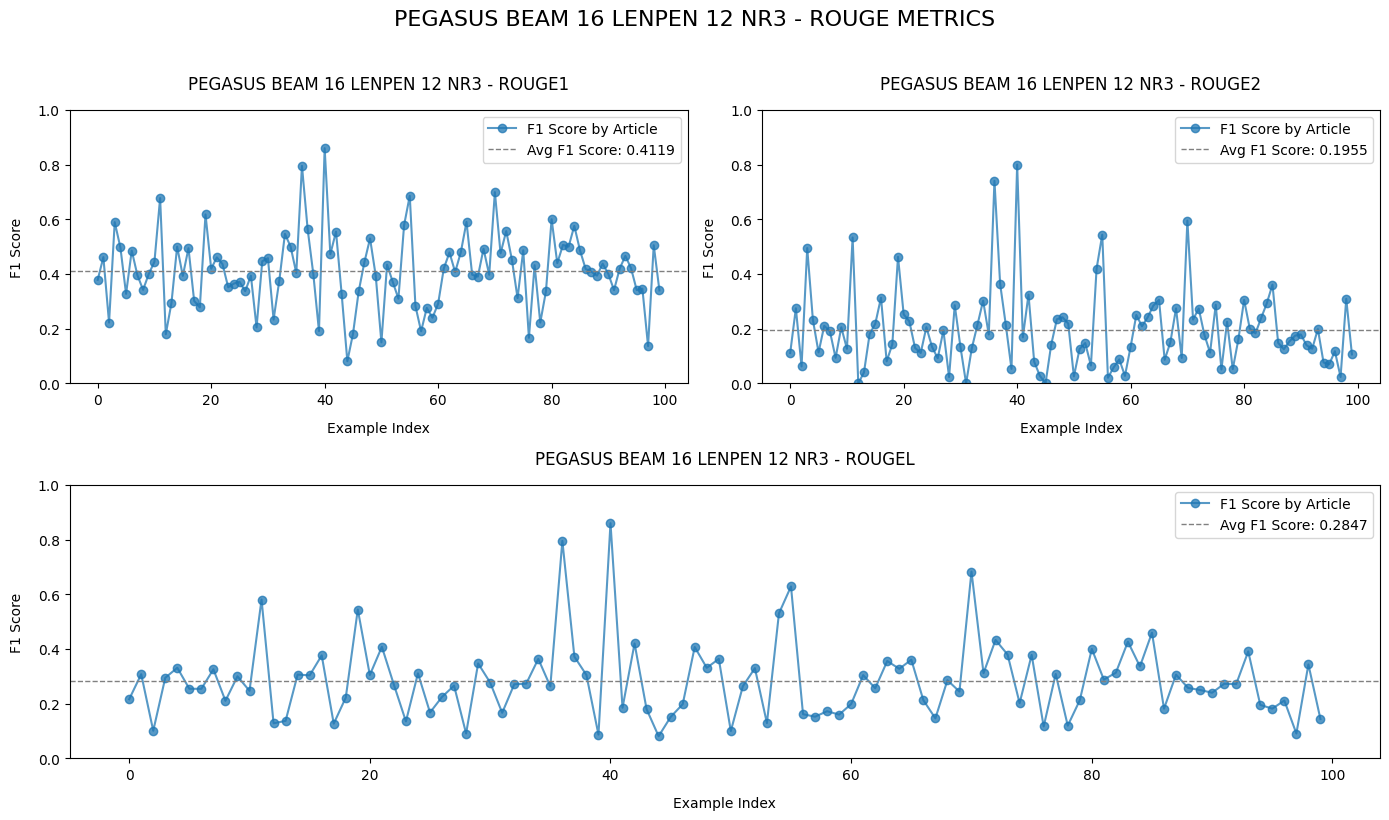

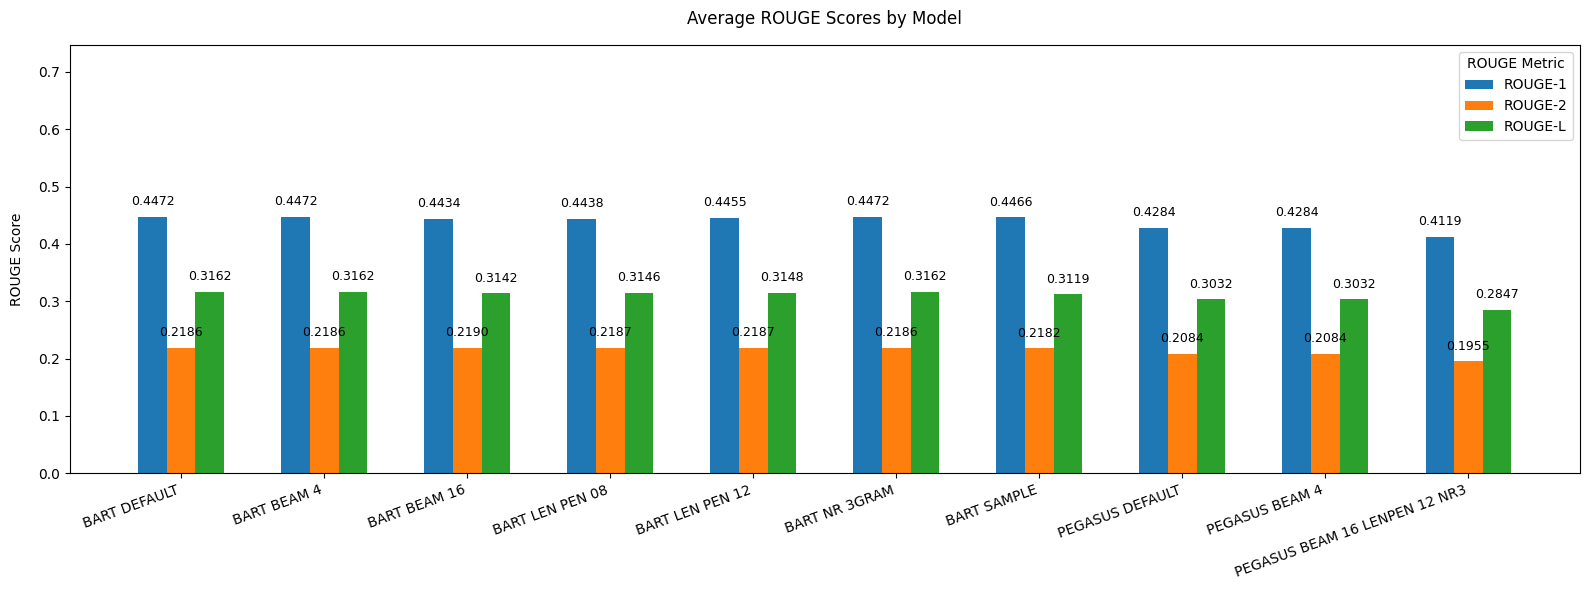

In [13]:
ablation_scores = sum_eval(articles, ablation_configs)
df_ablation = pd.DataFrame(ablation_scores).T.sort_values(by='rougeL', ascending=False)
plot_avg_rouge(ablation_scores, save_path=os.path.join(results_dir, 'ablation_avg_rouge_scores'))

#### Manual Evaluation



In [14]:
# Select 3 random articles
NUM_RANDOM_SAMPLES = 3
manual_ablation_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

##### BART DEFAULT

In [15]:
bart_default_summarizer = ablation_configs['bart_default']
bart_default_summaries = bart_default_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:15.69


In [42]:
# Evaluate Bart Default
bart_default_evaluator = ExtrinsicEvaluator(bart_default_summaries)
bart_default_evaluator.evaluate('BART DEFAULT')
bart_default_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Didn't finish thought, but would have been 5 if it had
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2 # awkward sentences "The 16-year-old is named after Brazil's former striker Ronaldo. But he is actually named after the original Brazilian Ronaldo, rather than Portugal star Cristiano."  
}
bart_default_evaluator.submit_scores(bart_default_id_to_score)

Manually evaluating BART DEFAULT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fail

##### BART BEAM 4

In [17]:
# Generate Summaries
bart_beam_4_summarizer = ablation_configs['bart_beam_4']
bart_beam_4_summaries = bart_beam_4_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:15.69


In [44]:
# Evaluate Bart Beam 4
bart_beam_4_evaluator = ExtrinsicEvaluator(bart_beam_4_summaries)
bart_beam_4_evaluator.evaluate('BART BEAM 4')
bart_beam_4_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Same as BART default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same as BART default
}
bart_beam_4_evaluator.submit_scores(bart_beam_4_id_to_score)

Manually evaluating BART BEAM 4...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the faile

##### BART BEAM 16

In [19]:
# Generate Summaries
bart_beam_16_summarizer = ablation_configs['bart_beam_16']
bart_beam_16_summaries = bart_beam_16_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:27.22


In [45]:
# Evaluate Bart Beam 16
bart_beam_16_evaluator = ExtrinsicEvaluator(bart_beam_16_summaries)
bart_beam_16_evaluator.evaluate('BART BEAM 16')
bart_beam_16_id_to_score = { 
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 3,  # Missing some details (New York, parent is a professor)  
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 4  # More relevant details, but same awkward phrasing
} 
bart_beam_16_evaluator.submit_scores(bart_beam_16_id_to_score)

Manually evaluating BART BEAM 16...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fail

##### BART LENGTH PENALTY 0.8

In [21]:
# Generate Summaries
bart_len_pen_08_summarizer = ablation_configs['bart_len_pen_08']
bart_len_pen_08_summaries = bart_len_pen_08_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:16.32


In [46]:
# Evaluate Bart Length Penalty 0.8
bart_len_pen_08_evaluator = ExtrinsicEvaluator(bart_len_pen_08_summaries)
bart_len_pen_08_evaluator.evaluate('BART LENGTH PENALTY 0.8')
bart_len_pen_08_id_to_score = {  
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Same as BART default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same as BART default
}
bart_len_pen_08_evaluator.submit_scores(bart_len_pen_08_id_to_score)

Manually evaluating BART LENGTH PENALTY 0.8...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, includi

##### BART LENGTH PENALTY 1.2

In [23]:
# Generate Summaries
bart_len_pen_12_summarizer = ablation_configs['bart_len_pen_12']
bart_len_pen_12_summaries = bart_len_pen_12_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:16.36


In [54]:
# Evaluate Bart Length Penalty 1.2
bart_len_pen_12_evaluator = ExtrinsicEvaluator(bart_len_pen_12_summaries)
bart_len_pen_12_evaluator.evaluate('BART LENGTH PENALTY 1.2')
bart_len_pen_12_id_to_score = {  
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Same as BART default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same as BART default
}
bart_len_pen_12_evaluator.submit_scores(bart_len_pen_12_id_to_score)

Manually evaluating BART LENGTH PENALTY 1.2...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, includi

##### BART NO-REP 3GRAM

In [25]:
# Generate Summaries
bart_nr_3gram_summarizer = ablation_configs['bart_nr_3gram']
bart_nr_3gram_summaries = bart_nr_3gram_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:16.40


In [47]:
# Evaluate BART NO-REP 3GRAM

bart_nr_3gram_evaluator = ExtrinsicEvaluator(bart_nr_3gram_summaries)
bart_nr_3gram_evaluator.evaluate('BART NO-REP 3-GRAM')
bart_nr_3gram_id_to_score = { 
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Same as BART default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same as BART default
}
bart_nr_3gram_evaluator.submit_scores(bart_nr_3gram_id_to_score)

Manually evaluating BART NO-REP 3-GRAM...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including th

##### BART SAMPLE

In [27]:
# Generate Summaries
bart_sample_summarizer = ablation_configs['bart_sample']
bart_sample_summaries = bart_sample_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:16.96


In [48]:
# Evaluate BART sample
bart_sample_evaluator = ExtrinsicEvaluator(bart_sample_summaries)
bart_sample_evaluator.evaluate('BART SAMPLE')
bart_sample_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 3,  # Same as BART default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Better than BART default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 5  # Significantly better than previous ones. Awkward phrasing cleared up
}
bart_sample_evaluator.submit_scores(bart_sample_id_to_score)

Manually evaluating BART SAMPLE...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the faile

##### PEGASUS DEFAULT

In [29]:
# Generate Summaries
pegasus_default_summarizer = ablation_configs['pegasus_default']
pegasus_default_summaries = pegasus_default_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:27.03


In [50]:
# Evaluate PEGASUS Default
pegasus_default_evaluator = ExtrinsicEvaluator(pegasus_default_summaries)
pegasus_default_evaluator.evaluate('PEGASUS DEFAULT')
pegasus_default_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 5,  # Almost exactly the same as the BART one, but finishes the sentence properly (GSG?)
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 2,  # All details there, some awkward phrasing, last sentence didnt make sense "Reddit, as user Bobitis."
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same issue as BART "The 16-year-old is named after Brazil's former striker Ronaldo .<n>But he is actually named after the original Brazilian Ronaldo, rather than Portugal star Cristiano" (interesting)
}
pegasus_default_evaluator.submit_scores(pegasus_default_id_to_score)

Manually evaluating PEGASUS DEFAULT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the f

##### PEGASUS BEAM 4

In [31]:
# Generate Summaries
pegasus_beam_4_summarizer = ablation_configs['pegasus_beam_4']
pegasus_beam_4_summaries = pegasus_beam_4_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:27.38


In [51]:
# Evaluate PEGASUS Beam 4
pegasus_beam_4_evaluator = ExtrinsicEvaluator(pegasus_beam_4_summaries)
pegasus_beam_4_evaluator.evaluate('PEGASUS BEAM 4')
pegasus_beam_4_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 5,  # Same as PEGASUS default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 2,  # Same as PEGASUS default
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 2  # Same as PEGASUS default
}
pegasus_beam_4_evaluator.submit_scores(pegasus_beam_4_id_to_score)

Manually evaluating PEGASUS BEAM 4...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fa

##### PEGASUS BEAM 16

In [33]:
# Generate Summaries
pegasus_beam_16_lenpen_12_nr3_summarizer = ablation_configs['pegasus_beam_16_lenpen_12_nr3']
pegasus_beam_16_lenpen_12_nr3_summaries = pegasus_beam_16_lenpen_12_nr3_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:01:4.34


In [52]:
# Evaluate PEGASUS Beam 16 Length Penalty 1.2 No-Rep 3-Gram
pegasus_beam_16_lenpen_12_nr3_evaluator = ExtrinsicEvaluator(pegasus_beam_16_lenpen_12_nr3_summaries)
pegasus_beam_16_lenpen_12_nr3_evaluator.evaluate('PEGASUS BEAM 16')
pegasus_beam_16_lenpen_12_nr3_id_to_score = {
    "406da8a5e3a90d4f91ba45689df958ea44b2e430": 5,  # Slighty less fluent language, but otherwise identical to PEGASUS default
    "18a5d47e83e935e37e38c149619751a1ac3eabd8": 5,  # Best example of this summary, perfect
    "502b6adb08503d0ccae8bba878912cacc95d06c4": 4  # Almost perfect, but has the same phrasing issue as BART "The 16-year-old is named after Brazil's former striker Ronaldo, who is pictured scoring in the 2002 World Cup.<n>But he is actually named after the original Brazilian Ronaldo, rather than Portugal star Cristiano."
}
pegasus_beam_16_lenpen_12_nr3_evaluator.submit_scores(pegasus_beam_16_lenpen_12_nr3_id_to_score)

Manually evaluating PEGASUS BEAM 16...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the f

## Manual Evaluation Results

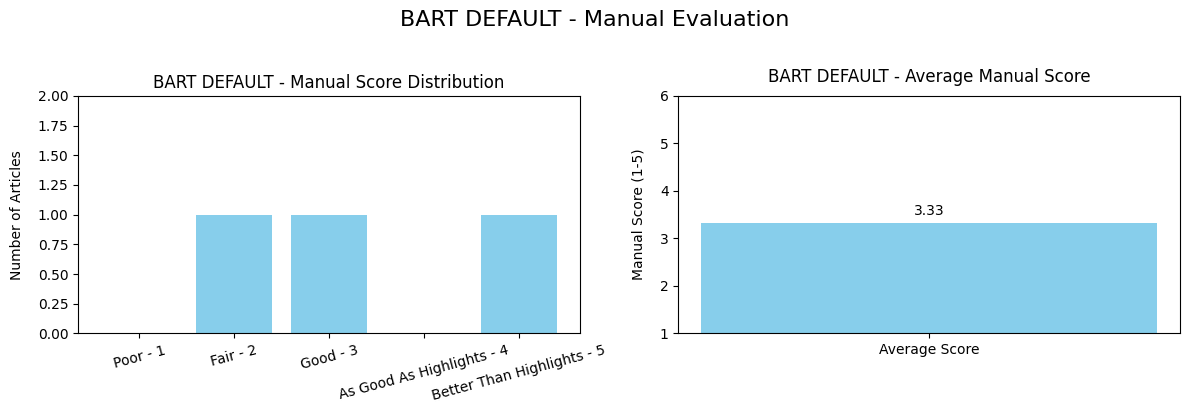

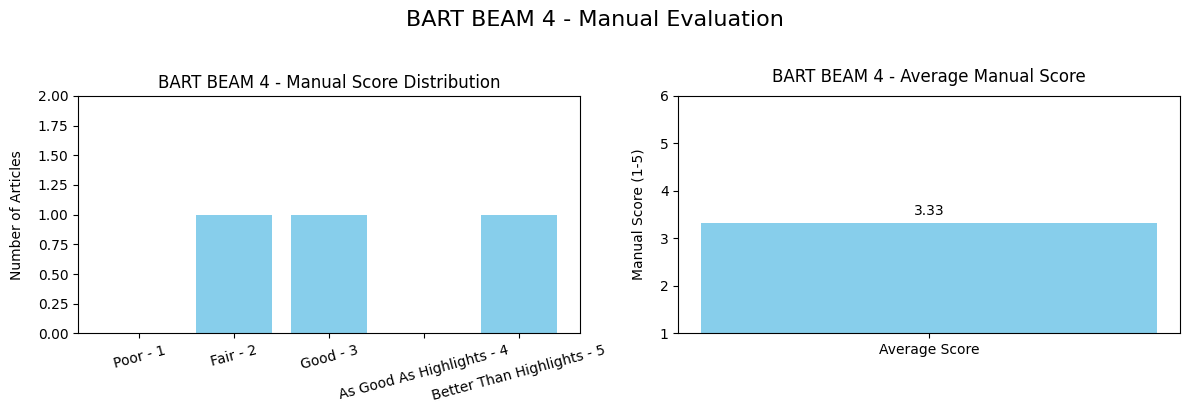

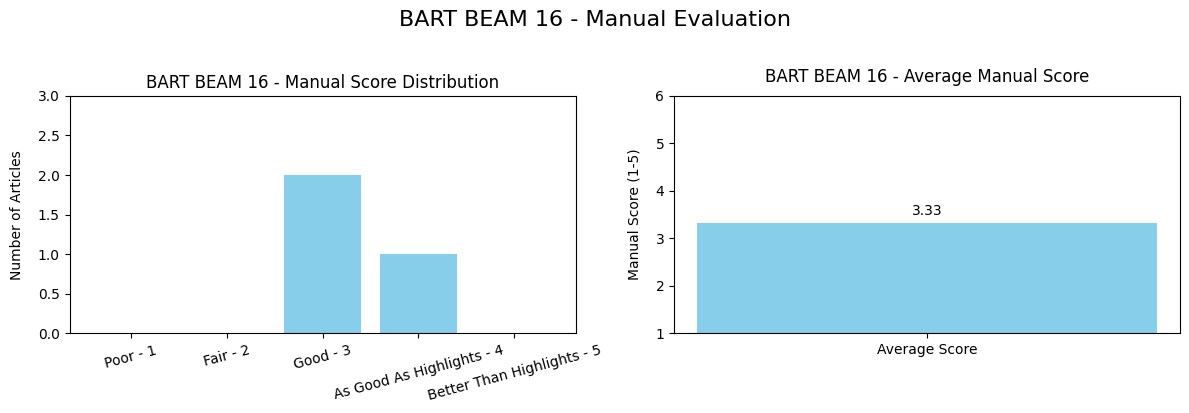

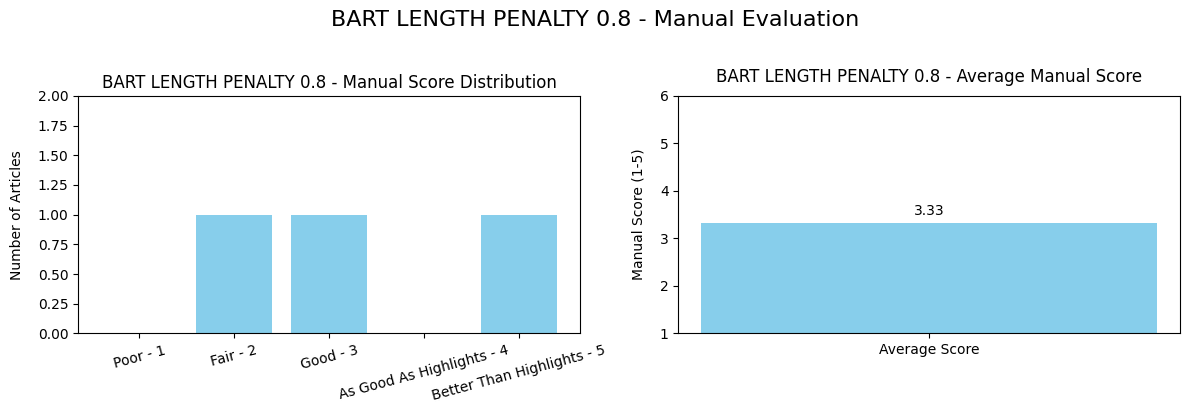

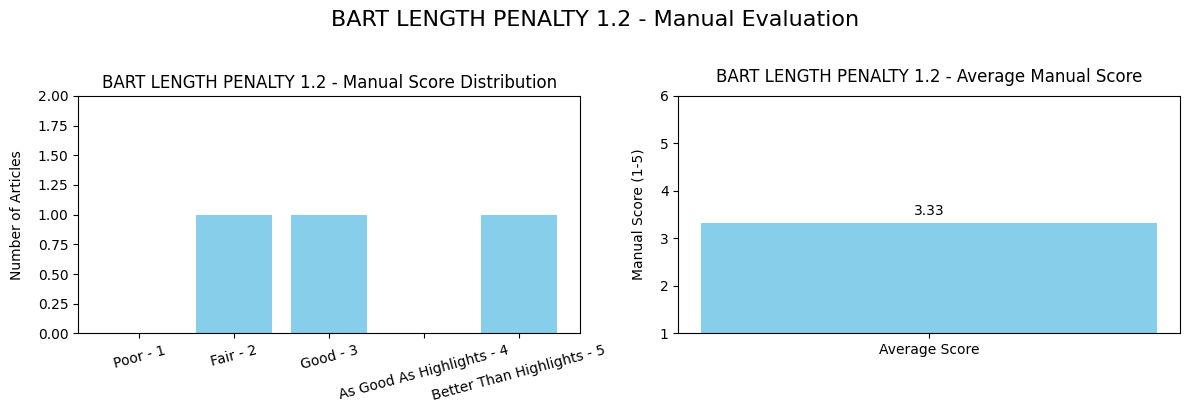

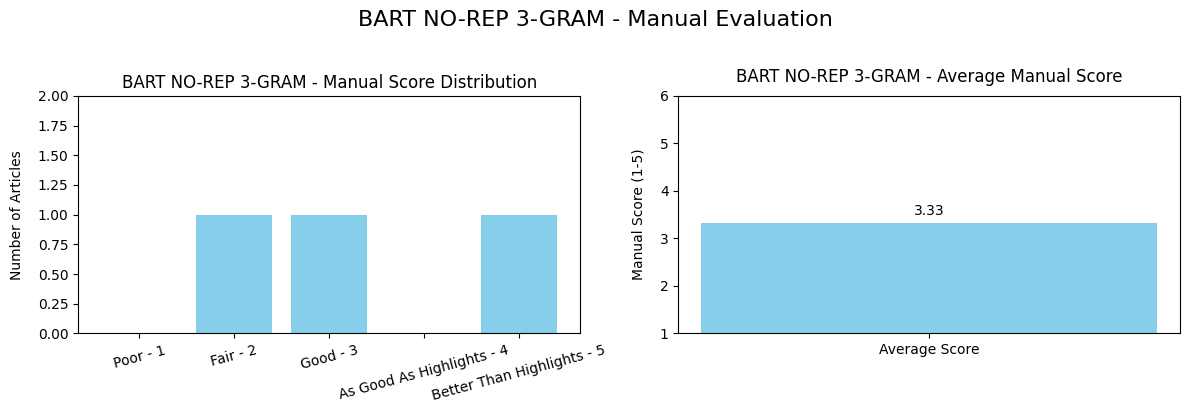

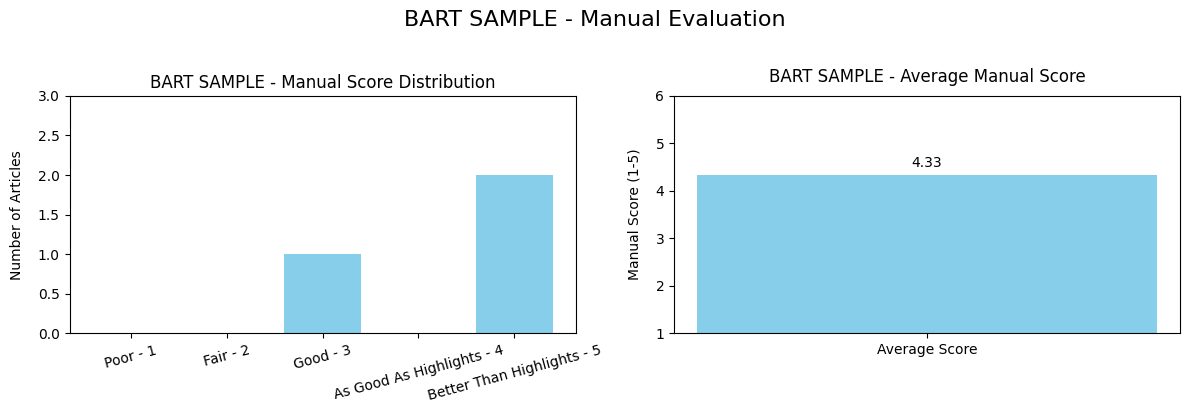

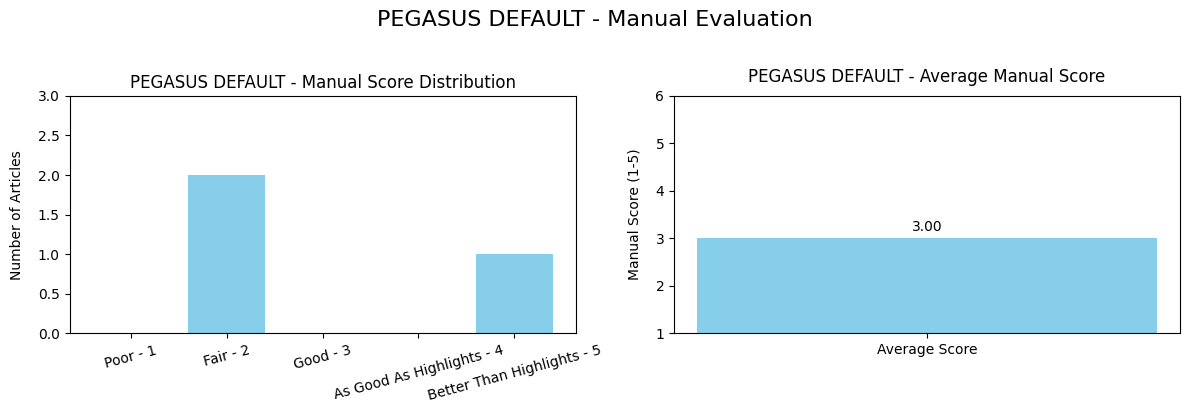

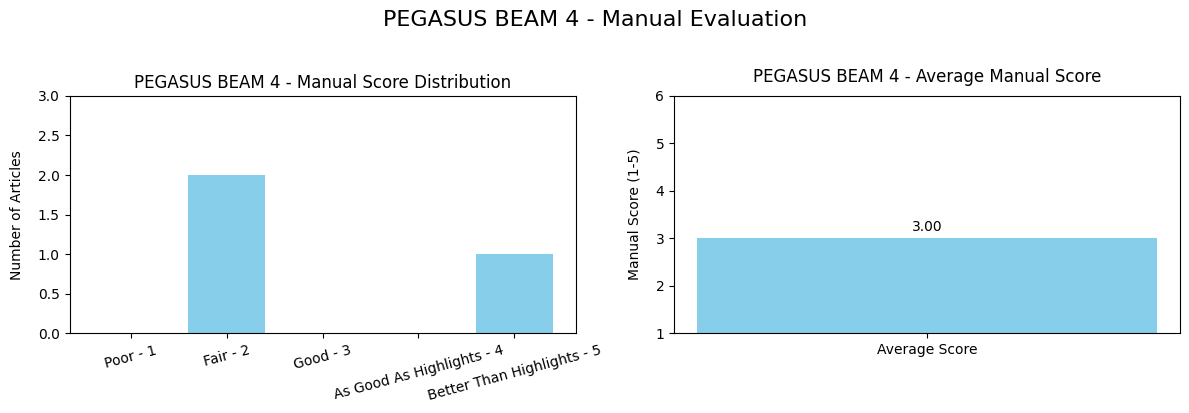

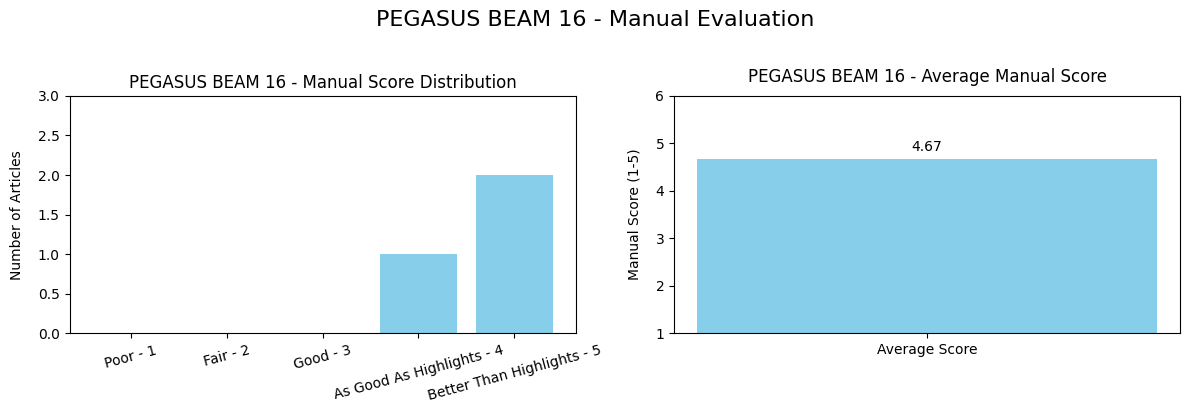

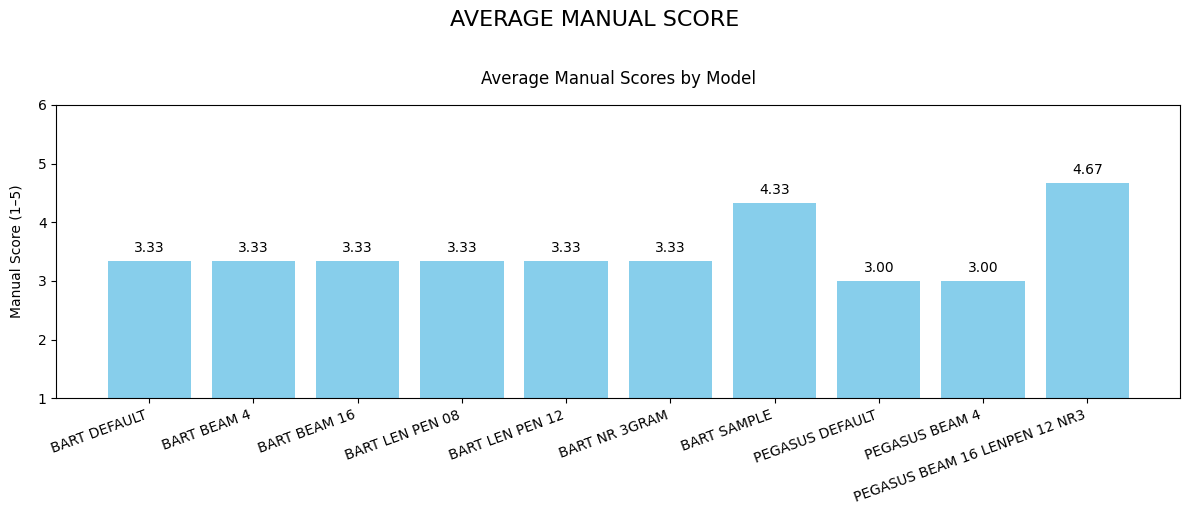

In [55]:
# Plot ablation models
bart_default_evaluator.plot('BART DEFAULT', save_path=os.path.join(results_dir, 'bart_default'))
bart_beam_4_evaluator.plot('BART BEAM 4', save_path=os.path.join(results_dir, 'bart_beam_4'))
bart_beam_16_evaluator.plot('BART BEAM 16', save_path=os.path.join(results_dir, 'bart_beam_16'))
bart_len_pen_08_evaluator.plot('BART LENGTH PENALTY 0.8', save_path=os.path.join(results_dir, 'bart_len_pen_08'))
bart_len_pen_12_evaluator.plot('BART LENGTH PENALTY 1.2', save_path=os.path.join(results_dir, 'bart_len_pen_12'))
bart_nr_3gram_evaluator.plot('BART NO-REP 3-GRAM', save_path=os.path.join(results_dir, 'bart_nr_3gram'))
bart_sample_evaluator.plot('BART SAMPLE', save_path=os.path.join(results_dir, 'bart_sample'))
pegasus_default_evaluator.plot('PEGASUS DEFAULT', save_path=os.path.join(results_dir, 'pegasus_default'))
pegasus_beam_4_evaluator.plot('PEGASUS BEAM 4', save_path=os.path.join(results_dir, 'pegasus_beam_4'))
pegasus_beam_16_lenpen_12_nr3_evaluator.plot('PEGASUS BEAM 16', save_path=os.path.join(results_dir, 'pegasus_beam_16_lenpen_12_nr3'))

ablation_avg_manual_scores = {
    'bart_default': bart_default_evaluator.avg_score,
    'bart_beam_4': bart_beam_4_evaluator.avg_score,
    'bart_beam_16': bart_beam_16_evaluator.avg_score,
    'bart_len_pen_08': bart_len_pen_08_evaluator.avg_score,
    'bart_len_pen_12': bart_len_pen_12_evaluator.avg_score,
    'bart_nr_3gram': bart_nr_3gram_evaluator.avg_score,
    'bart_sample': bart_sample_evaluator.avg_score,
    'pegasus_default': pegasus_default_evaluator.avg_score,
    'pegasus_beam_4': pegasus_beam_4_evaluator.avg_score,
    'pegasus_beam_16_lenpen_12_nr3': pegasus_beam_16_lenpen_12_nr3_evaluator.avg_score
}

plot_avg_manual_score(ablation_avg_manual_scores, save_path=os.path.join(results_dir, 'ablation_avg_manual_scores'))